Source to following code: https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/
<br>
Second source is: https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# %cd "/content/drive/My Drive/AutonomousDriving/Github/AutonomousCars/data/training_data"

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import statistics
import gc # Helps to clear up some ram

import cv2
from numpy import random
from imgaug import augmenters as img_aug

import math
import os

In [5]:
tf.random.set_seed(1)

In [7]:
import pickle

path = "/content/drive/My Drive/AutonomousDriving"
pickle_in = open(path+"/trainColour.pickle","rb")
# Remove binary version
trainImagesAndLabels = pickle.load(pickle_in)

imageId = []
bigImage = []
y_angle = []
y_speed = []
for id,image,lbl_angle,lbl_speed in trainImagesAndLabels:
  #checking = image
  if np.count_nonzero(pd.isnull(image)): 
    print("NA: This image was not read well so we will skip for now")
  else:
    imageId.append(id)
    bigImage.append(image)
    y_angle.append(lbl_angle)
    y_speed.append(lbl_speed)

In [8]:
import pickle

path = "/content/drive/My Drive/AutonomousDriving"
pickle_in = open(path+"/boxTrainNumeric.pickle","rb")
# Remove binary version
trainImagesAndLabels = pickle.load(pickle_in)

imageIdTest = []
boxes = []
classes = []
for id,appendage in trainImagesAndLabels:
    imageIdTest.append(id)
    boxes.append(appendage[0])
    classes.append(appendage[1])

In [9]:
"""
{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'box'},
 3: {'id': 3, 'name': 'green_traffic_light'},
 4: {'id': 4, 'name': 'red_traffic_light'},
 5: {'id': 5, 'name': 'tree'},
 6: {'id': 6, 'name': 'right_sign'},
 7: {'id': 7, 'name': 'left_sign'},
 8: {'id': 8, 'name': 'red_traffiic_light'}}
"""

"\n{1: {'id': 1, 'name': 'person'},\n 2: {'id': 2, 'name': 'box'},\n 3: {'id': 3, 'name': 'green_traffic_light'},\n 4: {'id': 4, 'name': 'red_traffic_light'},\n 5: {'id': 5, 'name': 'tree'},\n 6: {'id': 6, 'name': 'right_sign'},\n 7: {'id': 7, 'name': 'left_sign'},\n 8: {'id': 8, 'name': 'red_traffiic_light'}}\n"

In [10]:
def shrinkImage(image):
  height, _, _ = image.shape
  image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
  image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
  return image

In [11]:
X = []
for image in bigImage:
  X.append(shrinkImage(image))
del bigImage

In [12]:
def meanArea(imageClass,box,classID):
  index = np.where(imageClass == classID)[0]
  areaArray = np.zeros(len(index))
  
  
  for _ in range(len(index)):
    idx = index[_]
    area = (box[idx][3]-box[idx][1])*(box[idx][2]-box[idx][0])
    
    areaArray[_] = area

    
  meanArea = np.mean(areaArray)
  return meanArea

In [13]:
def assignSign(imageClass,box):  
  """
  0 = no sign
  1 = right sign
  2 = left sign
  """
  if 6 in imageClass:
    sign = 1
    boxArea = meanArea(imageClass,box,6)
  elif 7 in imageClass:
    sign = 2
    boxArea = meanArea(imageClass,box,7)
  elif 6 and 7 in imageClass:
    print('AHHHHHHHHHHHHHHHH')
  else:
    sign = 0
    boxArea = 0
  return boxArea,sign


In [18]:
boxList = []
signList = []
for idx in range(len(classes)):
  # boxes,classes = objectDetect(image)
  boxArea, sign = assignSign(classes[idx],boxes[idx])
  boxList.append(boxArea)
  signList.append(sign)

# Prepare to input sign information
### 6/8 = right_sign
### 7/8 = left_sign

Standard deviation of the angles

In [ ]:
plt.hist(y_angle)
statistics.stdev(y_angle)

In [19]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image
    
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image


def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

In [20]:
def random_augment(image, steering_angle):
  
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle
# imageId = np.array(imageId)

In [21]:
smallAngles=(np.where(np.array(y_angle)<0.5)[0])
largeAngles=(np.where(np.array(y_angle)>=0.8)[0])
tinyAngles=(np.where(np.array(y_angle)<0.3)[0])
hugeAngles=(np.where(np.array(y_angle)>=0.9)[0])
augmentedImages = []
augmentedAngles = []
augmentedID = []
augmentedBoxes = []
augmentedClasses = []
for idx in smallAngles:
  image, angle = random_augment(X[idx], y_angle[idx])
  augmentedImages.append(image)
  augmentedAngles.append(angle)
  augmentedID.append(imageId[idx])
  augmentedClasses.append(signList[idx])
  augmentedBoxes.append(boxList[idx])

In [22]:
for idx in hugeAngles:
  for _ in range(4):
    image, angle = random_augment(X[idx], y_angle[idx])
    augmentedImages.append(image)
    augmentedAngles.append(angle)
    augmentedID.append(imageId[idx])
    augmentedClasses.append(signList[idx])
    augmentedBoxes.append(boxList[idx])

In [23]:
for idx in tinyAngles:
  for _ in range(4):
    image, angle = random_augment(X[idx], y_angle[idx])
    augmentedImages.append(image)
    augmentedAngles.append(angle)
    augmentedID.append(imageId[idx])
    augmentedClasses.append(signList[idx])
    augmentedBoxes.append(boxList[idx])

In [24]:
for idx in largeAngles:
  image, angle = random_augment(X[idx], y_angle[idx])
  augmentedImages.append(image)
  augmentedAngles.append(angle)
  augmentedID.append(imageId[idx])
  augmentedClasses.append(signList[idx])
  augmentedBoxes.append(boxList[idx])

Hist before augmentation

0.15555820377620497

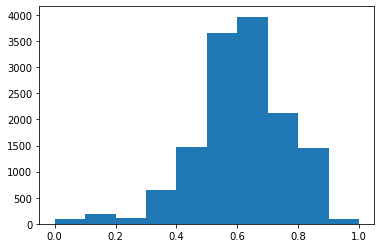

In [25]:
plt.hist(y_angle)
statistics.stdev(y_angle)

Hist after augmentation

In [26]:
for idx in range(len(augmentedAngles)):
  y_angle.append(augmentedAngles[idx])
  X.append(augmentedImages[idx])
  imageId.append(augmentedID[idx])
  boxList.append(augmentedBoxes[idx])
  signList.append(augmentedClasses[idx])

In [76]:
plt.hist(np.array(y_angle))
statistics.stdev(y_angle)

NameError: ignored

Now we can find how many duplicate angles there exist in the y_angles

In [ ]:
# (unique, counts) = np.unique(y_angle, return_counts=True)

In [ ]:
# print("Unique angles =",len(unique))
# print("The total length of the angle array is",len(y_angle))

In [ ]:
# print( np.asarray((unique, counts)).T )

In [ ]:
# print(y_angle)
# print(imageId)

The fact that there are only 17 angles allows us to only use some images

In [27]:
X_new = X
y_angle_new = y_angle
idImage = imageId
del X
del y_angle
del imageId

In [28]:
X_new = np.array(X_new)
y_angle_new = np.array(y_angle_new)
idImage = np.array(idImage)
signArray = np.array(signList)
boxArray = np.array(boxList)
# print(X_new.shape)
# print(y_angle_new.shape)
# print(idImage.shape)

Preprocces images to scale, normalize change RGB to YUV and add gaussian noise

In [29]:
def img_preprocess(image):
    height, _, _ = image.shape

    # in the case that there exists an object in the image of interest DO NOT MAKE reduce the height of the image!!

    # image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0) # Gaussian Noise / filtering
    # image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    # Round everything into the image to 1 decimal place
    image = np.around(image ,2)
    return image

In [30]:
X_final = []
for img_index in range(X_new.shape[0] ):
  X_f = img_preprocess(X_new[img_index,:,:,:])
  X_final.append(X_f)

In [31]:
X_final = np.array(X_final)
# X_final = np.array(X_final, dtype=np.float16)

In [63]:
X_box_inputs = (np.vstack([signArray,boxArray])).T

In [64]:
X_box_inputs.shape

(19794, 2)

Create a test dataset to ensure that we do not overfit

In [65]:
from keras.layers import *
X_train_image, X_test_image, X_train_box, X_test_box, y_train, y_test = train_test_split(X_final, X_box_inputs, y_angle_new, test_size=0.1, random_state=42)

In [ ]:
# #shuffle x and y together
# perms = np.random.permutation(len(X_final))
# X_train = X_final[perms]
# y_train = y_angle_new[perms]

In [ ]:
del y_angle_new
del X_final

In [ ]:
# plt.imshow(X_train[22])#,:,:,:])
# print(y_train[22])
# #print(idImage[21])

In [67]:
# print(X_train.shape)
tf_y_train = tf.reshape(y_train,[ y_train.shape[0] ,1 ]).numpy()
print(y_train.shape)
print(tf_y_train.shape)

(17814,)
(17814, 1)


In [68]:
from keras.models import *
def scalar_model():
  # model = Sequential(name='angle input')
  input = Input(shape=(X_train_box.shape[1]))
  x= (Dense(1,activation ='relu'))(input)
  x = Dense(100,activation ='relu')(x)
  # x = Dense(200,activation ='relu')(x)
  # x = (Dense(50, activation = 'relu'))(x)
  output = x
  model = Model(inputs=input,outputs=output)
  return model

scalar_model = scalar_model()
# angle_top_model.summary()

In [ ]:
def nvidia_top_model():
    
    
    # elu=Exponential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    inputs = Input(shape=(X_train_image.shape[1], X_train_image.shape[2], X_train_image.shape[3]))
    x = BatchNormalization()(inputs)
    x = (Conv2D(24, (5, 5), strides=(2, 2), activation='elu',))(x)#(inputs)# input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation='elu')) 
    x = (Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))(x)
    x = MaxPooling2D(padding='same')(x)
    x = (Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))(x)
    # x = MaxPooling2D(padding='same')(x)
    x = (Conv2D(64, (2, 2), activation='elu'))(x) 
    #model.add(Dropout(0.2)) # not in original model. added for more robustness
    x = (Conv2D(64, (1, 1), activation='elu'))(x)  
    
    # Fully Connected Layers
    x = (Flatten())(x)
    x = (Dense(200, activation='elu'))(x)

    x = (Dropout(0.1))(x) # not in original model. added for more robustness
    x = (Dense(100, activation='elu'))(x)
    #model.add(Dense(100, activation='elu'))
    # x = (Dropout(0.1))(x)
    # x = (Dense(50, activation='elu'))(x)
    #model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.05))
    # x = (Dense(10, activation='elu'))(x)
    outputs = x
    #model.add(Dense(10, activation='elu'))
    
    model = Model(inputs=inputs, outputs=outputs )
    return model

nvidia_top_model = nvidia_top_model()
print(nvidia_top_model.summary())

In [70]:
mergedOut = Add()([nvidia_top_model.output,scalar_model.output])

mergedOut = Flatten()(mergedOut)    
# mergedOut = Dense(50, activation='relu')(mergedOut)
# mergedOut = Dense(200, activation='elu')(mergedOut)
mergedOut = Dense(100, activation='elu')(mergedOut)
mergedOut = Dense(50, activation='elu')(mergedOut)
mergedOut = Dense(10, activation='elu')(mergedOut)
# mergedOut = Dropout(.1)(mergedOut)
# mergedOut = Dense(5, activation='relu')(mergedOut)
# mergedOut = Dropout(.1)(mergedOut)

# output layer
mergedOut = Dense(1)(mergedOut)

In [ ]:
from keras.models import Model

mergeModel = Model([nvidia_top_model.input, scalar_model.input], mergedOut)
optimizer = Adam(lr=1e-3)
mergeModel.compile(loss='mse',
                  optimizer=optimizer               
                  )
mergeModel.summary()

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=7, verbose=1, mode='auto',
        restore_best_weights=True)
mergeModel.fit([X_train_image,X_train_box], tf_y_train, batch_size=128, epochs=100, validation_split=0.2,callbacks=[monitor])  

In [75]:
mergeModel.evaluate(x=[X_test_image,X_test_box],y=y_test)

62/62 [==============================] - 1s 10ms/step - loss: 0.0113


0.011269586160779

In [ ]:
# model.save(os.path.join(path,'Angle_prediction_model.h5'))

In [ ]:
steering_angle = model.predict(X_test)

In [ ]:
gc.collect()

13819

In [ ]:
steering_angle = np.around(steering_angle,4)

In [ ]:
errors = []
indexes=[]
for _ in range(len(y_test)):
  errors.append(y_test[_]-steering_angle[_])
  indexes.append(_)

In [ ]:
frame = pd.DataFrame([errors,indexes,y_test,steering_angle]).T

In [ ]:
y_test

array([0.1875, 0.125 , 0.5625, ..., 0.625 , 0.    , 0.8125])

In [ ]:
frame.columns=['errors','indexes','y_test','y_pred']
frame.sort_values("errors",inplace=True)
frame.set_index("indexes",inplace=True)
frame.head(40)

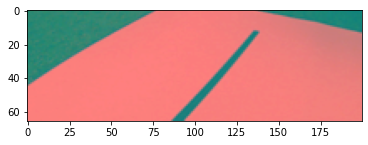

In [ ]:
plt.imshow(X_test[1326])

In [ ]:
for i in range(y_test.shape[0]):  
  #print([steering_angle[i][0], tf_y_angle[i][0]])
  print([steering_angle[i][0], y_test[i] ])

(array([ 528., 1182.,  624., 1282., 2934., 3655., 3970., 2123., 2896.,
         200.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

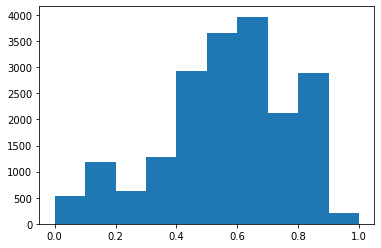

In [ ]:
plt.hist(y_angle_new)

Calculate the Mean squared error

In [ ]:
mseSum = 0
print(y_test.shape[0])
for i in range(y_test.shape[0]):
  mseSum += (1/y_test.shape[0] ) *  (steering_angle[i][0] - y_test[i])**2
print(mseSum)

1980
0.012001457926274885


In [ ]:
model.save(os.path.join(path,'Angle_prediction_model.h5'))

In [ ]:
del model

In [ ]:
model = load_model(path+'/Angle_prediction_model.h5')

Now save the model output

In [ ]:
#import os
# always save model output as soon as model finishes training
#model.save(os.path.join(path,'angle_prediction.h5'))

In [ ]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(32))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.fit(X, y_speed, batch_size=32, epochs=2, validation_split=0.8)

Run the same model as above for angle prediction but change the loss function since we do not have classification. ALso accuracy is not a term to measure.

In [ ]:
#y_angle

In [ ]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(64))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='mean_squared_error',
#               optimizer='adam')

# model.fit(X, y_angle, batch_size=32, epochs=2, validation_split=0.95)